<a href="https://colab.research.google.com/github/fanroyi/E4511-2021-Fan/blob/main/Random_Forest_Classification_model_and_test_new_data_with_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

# get the Anaconda file 
! wget -c https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
! chmod +x Anaconda3-2019.10-Linux-x86_64.sh
! bash ./Anaconda3-2019.10-Linux-x86_64.sh -b -f -p /usr/local

! time conda install -y -c deepchem -c rdkit -c conda-forge -c omnia deepchem-gpu=2.3.0

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
import deepchem as dc

# install mordred, bravado and molvs
! time conda install -c conda-forge -y mordred bravado molvs

# get the Install AMPL_GPU_test.sh
!wget https://raw.githubusercontent.com/ravichas/AMPL-Tutorial/master/config/install_AMPL_GPU_test.sh

# run the script to install AMPL
! chmod u+x install_AMPL_GPU_test.sh
! ./install_AMPL_GPU_test.sh

!pip install hyperopt

# FutureWarnings and DeprecationWarnings are present from some of the AMPL 
# dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
# import numpy as np
# import pandas as pd
import os
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set_context("poster")
sns.set_style("whitegrid")
sns.set_palette("Set2")

import pandas as pd
import os, json, sys, glob, pickle

TensorFlow 1.x selected.
--2021-04-28 22:30:18--  https://repo.anaconda.com/archive/Anaconda3-2019.10-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 530308481 (506M) [application/x-sh]
Saving to: ‘Anaconda3-2019.10-Linux-x86_64.sh’

Anaconda3-2019.10-L 100%[===================>] 505.74M   108MB/s    in 4.7s    

2021-04-28 22:30:22 (108 MB/s) - ‘Anaconda3-2019.10-Linux-x86_64.sh’ saved [530308481/530308481]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _ipyw_jlab_nb_ext_conf==0.1.0=py37_0
    - _libgcc_mutex==0.1=main
    - alabaster==0.7.12=py37_0
    - anaconda-client==1.7.2=py37_0
    - a

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - bravado
    - molvs
    - mordred


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    bravado-11.0.3             |     pyhd8ed1ab_0          31 KB  conda-forge


In [2]:
! pip install bravado

  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-any.whl size=18120 sha256=72d971b7be435d30daa9991cb556d0e4d8fe2a038bff9a3ba52ffa5817555138
  Stored in directory: /root/.cache/pip/wheels/bb/af/c9/b6e9fb5f9b2470e4ed2a7241c9ab3a8cdd3bc8555ae02ca2e6
Successfully built strict-rfc3339


In [3]:
#! time conda install -c conda-forge -y mordred bravado molvs
# There is a problem with the previously imported cffi, so delete it and load it with AMPL instead
#if 'cffi' in sys.modules:
#  del sys.modules['cffi']
#import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import model_pipeline as mp
import atomsci.ddm.pipeline.compare_models as cmp
from atomsci.ddm.pipeline import parameter_parser as parse
from atomsci.ddm.pipeline import perf_data

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [4]:
! wget https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/curated_combined_df_1.csv

--2021-04-28 22:45:58--  https://raw.githubusercontent.com/fanroyi/E4511-2021-Fan/main/Dataset/curated_combined_df_1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 630606 (616K) [text/plain]
Saving to: ‘curated_combined_df_1.csv’

curated_combined_df 100%[===================>] 615.83K  --.-KB/s    in 0.07s   

2021-04-28 22:45:58 (8.96 MB/s) - ‘curated_combined_df_1.csv’ saved [630606/630606]



In [5]:
import pandas as pd
df = pd.read_csv('curated_combined_df_1.csv', index_col=0)
df

,compound_id,base_rdkit_smiles,PXC50,active,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,VALUE_NUM_mean
0,JOJYHYRCIYAVHN-UHFFFAOYSA-N,Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1,4.408935,0,0.000753,0.012072,0,4.409468
1,CKLPLPZSUQEDRT-WPCRTTGESA-N,C[C@H]1Cc2c([nH]c3cc(Cl)c(F)cc23)[C@@]2(N1)C(=...,5.266001,0,0.002828,0.037958,0,5.268000
2,HHVBUSGGPUQAOP-UHFFFAOYSA-N,Cc1cccc(Sc2ccccc2N2CCNCC2)c1C,4.397940,0,0.001189,0.031217,0,4.399313
3,RJOWFEDJGNNCDF-UHFFFAOYSA-N,Clc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1,4.468521,0,0.000854,0.022059,0,4.469507
4,REFJWTPEDVJJIY-UHFFFAOYSA-N,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,4.991400,0,0.000990,0.014024,0,4.990700
...,...,...,...,...,...,...,...,...
7642,CHEMBL1372952,COc1ccc2[nH]c(Sc3c([N+](=O)[O-])nc(C)n3Cc3cccc...,4.800000,0,NaN,0.000000,0,4.800000
7643,CHEMBL1335370,O=C(CSc1ccccc1)Nc1ccc(N2CCN(c3ccccc3)CC2)c(F)c1,6.350000,1,NaN,0.000000,0,6.350000
7644,CHEMBL103,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4CC(=O)CC[C@]4(...,5.260000,1,NaN,0.000000,0,5.260000
7645,CHEMBL1522767,NC(=NOC(=O)Cc1ccc(-c2ccccc2)cc1)c1cccc([N+](=O...,5.000000,1,NaN,0.000000,0,5.000000


In [6]:
df[df.compound_id.duplicated(keep=False)==True].sort_values(by='compound_id')

,compound_id,base_rdkit_smiles,PXC50,active,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,VALUE_NUM_mean


In [7]:
print('the min value to label active is:',min(df.loc[df.active==1]['VALUE_NUM_mean']))
print('the number of active is:', len(df.loc[df.active==1]))

the min value to label active is: 5.0
the number of active is: 3692


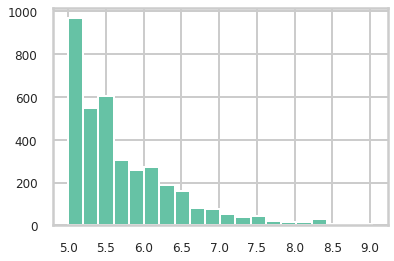

active/non-active ratio 0.10633680555555555


In [8]:
import matplotlib.pyplot as plt
plt.hist(df.loc[df.active==1]['VALUE_NUM_mean'], bins=20)
plt.show()
# maybe a cut off point >6.21 is good choice
print('active/non-active ratio',len(df.loc[df.VALUE_NUM_mean>6.21])/len(df.loc[df.VALUE_NUM_mean<=6.21]))

In [9]:
import numpy as np
# create new label with new cut off point.
df['new_active']=np.where(df.VALUE_NUM_mean>6.21,1,0)
df

,compound_id,base_rdkit_smiles,PXC50,active,VALUE_NUM_std,Perc_Var,Remove_BadDuplicate,VALUE_NUM_mean,new_active
0,JOJYHYRCIYAVHN-UHFFFAOYSA-N,Cc1ccc(Sc2ccccc2N2CCNCC2)c(C)c1,4.408935,0,0.000753,0.012072,0,4.409468,0
1,CKLPLPZSUQEDRT-WPCRTTGESA-N,C[C@H]1Cc2c([nH]c3cc(Cl)c(F)cc23)[C@@]2(N1)C(=...,5.266001,0,0.002828,0.037958,0,5.268000,0
2,HHVBUSGGPUQAOP-UHFFFAOYSA-N,Cc1cccc(Sc2ccccc2N2CCNCC2)c1C,4.397940,0,0.001189,0.031217,0,4.399313,0
3,RJOWFEDJGNNCDF-UHFFFAOYSA-N,Clc1ccc(Sc2ccccc2N2CCNCC2)c(Cl)c1,4.468521,0,0.000854,0.022059,0,4.469507,0
4,REFJWTPEDVJJIY-UHFFFAOYSA-N,O=c1c(O)c(-c2ccc(O)c(O)c2)oc2cc(O)cc(O)c12,4.991400,0,0.000990,0.014024,0,4.990700,0
...,...,...,...,...,...,...,...,...,...
7642,CHEMBL1372952,COc1ccc2[nH]c(Sc3c([N+](=O)[O-])nc(C)n3Cc3cccc...,4.800000,0,NaN,0.000000,0,4.800000,0
7643,CHEMBL1335370,O=C(CSc1ccccc1)Nc1ccc(N2CCN(c3ccccc3)CC2)c(F)c1,6.350000,1,NaN,0.000000,0,6.350000,1
7644,CHEMBL103,CC(=O)[C@H]1CC[C@H]2[C@@H]3CC=C4CC(=O)CC[C@]4(...,5.260000,1,NaN,0.000000,0,5.260000,0
7645,CHEMBL1522767,NC(=NOC(=O)Cc1ccc(-c2ccccc2)cc1)c1cccc([N+](=O...,5.000000,1,NaN,0.000000,0,5.000000,0


In [10]:
df.to_csv('df_classification_new_cutoff_label.csv')

In [11]:
working_dir = '/content'

In [12]:
# data splits based on the scaffold of small molecules.
featurizer = 'ecfp' 
model_type = 'RF'
response_col = ['new_active']
smiles_col = 'base_rdkit_smiles'
compound_id = 'compound_id'
train_file = 'df_classification_new_cutoff_label.csv'
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",   #Boolean flag for using an input file from the LLNL specific datastore system based on a key of dataset_key
        "save_results": "False", # Save model results to MongoDB,
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "previously_split": "False",  # Boolean flag for loading in previously split train, validation, and test csv files
        "split_only": "True",   # indicate splitting of the datasets when running the hyperparameter search
        'split_strategy':'train_valid_test',
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": working_dir
    }

ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 22:47:42,030 Splitting data by scaffold
2021-04-28 22:47:48,143 Dataset split table saved to /df_classification_new_cutoff_label_train_valid_test_scaffold_ab5c1e11-9dfa-4bc4-baeb-11d354654647.csv


In [13]:
split_uuid = pl.split_dataset()
split_uuid

number of features: 1024


2021-04-28 22:49:03,990 Splitting data by scaffold
2021-04-28 22:49:10,034 Dataset split table saved to /df_classification_new_cutoff_label_train_valid_test_scaffold_23b58437-056d-4cc6-9911-e22c724261de.csv


'23b58437-056d-4cc6-9911-e22c724261de'

# Train Initial Rf

In [14]:
# train inital rf model

response_col = "new_active"
# default : rf_estimators=500, rf_max_features = 32
params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,   # UUID for csv file containing train, validation, and test split information
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',
        "rerun": "False",
        "result_dir": "ampl_output"
    }

In [15]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 22:50:00,162 Previous dataset split restored
2021-04-28 22:50:23,691 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/b5cc42ec-66ef-4c94-ae10-26a87d5fdaff/model_metadata.json
2021-04-28 22:50:24,163 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/b5cc42ec-66ef-4c94-ae10-26a87d5fdaff/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_b5cc42ec-66ef-4c94-ae10-26a87d5fdaff.tar.gz


In [16]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")

R2 score of validation set: 0.657


In [17]:
pred_data = pl.model_wrapper.get_perf_data(subset="test", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of test set: {pred_results['roc_auc_score']:.3f}")

R2 score of test set: 0.795


In [18]:
# Adding uncertainty to base training model
# The glob module finds all the pathnames matching a specified pattern according to the rules


params = {
        "system": "LC",
        "lc_account": 'None',
        "datastore": "False",
        "save_results": "False",
        "data_owner": "username",
        "prediction_type": "classification",
        "dataset_key": train_file,
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_col,
        "split_uuid": split_uuid,
        "previously_split": "True",
        "featurizer": "ecfp",
        "model_type": "RF",       #Random forest
        "verbose": "True",
        "transformers": "True",
        'max_epochs': '70',      # Maximum number of training epochs to run for DNN models. Default 30.
        "rerun": "False",
        "result_dir": "ampl_output",
        "uncertainty": "True"  # Boolean flag for computing uncertainty estimates for regression model predictions. 
    }

In [19]:
ampl_param = parse.wrapper(params)
pl = mp.ModelPipeline(ampl_param)
pl.train_model()

number of features: 1024


2021-04-28 22:51:01,876 Previous dataset split restored
2021-04-28 22:51:27,572 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3a420d0b-3903-41c3-8bb0-68493081466f/model_metadata.json
2021-04-28 22:51:28,022 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3a420d0b-3903-41c3-8bb0-68493081466f/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_3a420d0b-3903-41c3-8bb0-68493081466f.tar.gz


In [20]:
pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
pred_results = pred_data.get_prediction_results()
print(f"R2 score of validation set: {pred_results['roc_auc_score']:.3f}")

R2 score of validation set: 0.646


In [ ]:
# Grid Search 1

# Grid Search 1

In [21]:
n_estimator = [100,200,300,400,500]
rf_max_depth = [70,150,200]
rf_max_features = [10,50,100]


rfe_list = []
rfd_list = []
rff_list = []
valid_r2_list = []
for rf_estimator in n_estimator:
    for rf_depth in rf_max_depth:
        for rf_feature in rf_max_features:
            params["rf_estimators"] = rf_estimator
            params["rf_max_depth"] = rf_depth
            params["rf_max_features"] = rf_feature
            rfe_list.append(rf_estimator)
            rfd_list.append(rf_depth)
            rff_list.append(rf_feature)
            tp = parse.wrapper(params)
            pl = mp.ModelPipeline(tp)
            pl.train_model()
            pred_data = pl.model_wrapper.get_perf_data(subset="valid", epoch_label="best")
            pred_results = pred_data.get_prediction_results()
            valid_r2 = pred_results['roc_auc_score']
            valid_r2_list.append(valid_r2)
            print(f"rf_estimators: {rf_estimator}, rf_max_depth: {rf_depth}, rf_max_features: {rf_feature}, valid_r2: {valid_r2}")

number of features: 1024


2021-04-28 22:52:05,536 Previous dataset split restored
2021-04-28 22:52:10,696 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/4d101cc4-fc62-461d-adcd-54030603b6f9/model_metadata.json
2021-04-28 22:52:10,834 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/4d101cc4-fc62-461d-adcd-54030603b6f9/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_4d101cc4-fc62-461d-adcd-54030603b6f9.tar.gz
rf_estimators: 100, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.6104179250981576
number of features: 1024


2021-04-28 22:52:47,967 Previous dataset split restored
2021-04-28 22:52:56,233 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3d312e0a-cce2-475e-88bf-7ccd0b8a7966/model_metadata.json
2021-04-28 22:52:56,317 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3d312e0a-cce2-475e-88bf-7ccd0b8a7966/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_3d312e0a-cce2-475e-88bf-7ccd0b8a7966.tar.gz
rf_estimators: 100, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.6865372999093929
number of features: 1024


2021-04-28 22:53:33,409 Previous dataset split restored
2021-04-28 22:53:46,070 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fbebe141-2b4f-4ad9-913d-6210a765dc5c/model_metadata.json
2021-04-28 22:53:46,148 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fbebe141-2b4f-4ad9-913d-6210a765dc5c/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_fbebe141-2b4f-4ad9-913d-6210a765dc5c.tar.gz
rf_estimators: 100, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.6345798097251585
number of features: 1024


2021-04-28 22:54:23,741 Previous dataset split restored
2021-04-28 22:54:29,005 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d4e945f3-4c26-4c95-a31d-ef7198238827/model_metadata.json
2021-04-28 22:54:29,149 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d4e945f3-4c26-4c95-a31d-ef7198238827/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_d4e945f3-4c26-4c95-a31d-ef7198238827.tar.gz
rf_estimators: 100, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.644603216550891
number of features: 1024


2021-04-28 22:55:06,223 Previous dataset split restored
2021-04-28 22:55:14,564 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/8d2d45e4-39b3-422e-9e84-cb0f9a9fe200/model_metadata.json
2021-04-28 22:55:14,650 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/8d2d45e4-39b3-422e-9e84-cb0f9a9fe200/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_8d2d45e4-39b3-422e-9e84-cb0f9a9fe200.tar.gz
rf_estimators: 100, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.6461038961038961
number of features: 1024


2021-04-28 22:55:51,739 Previous dataset split restored
2021-04-28 22:56:04,622 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/7e28d17f-d81e-4271-a4de-02809ccc054b/model_metadata.json
2021-04-28 22:56:04,696 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/7e28d17f-d81e-4271-a4de-02809ccc054b/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_7e28d17f-d81e-4271-a4de-02809ccc054b.tar.gz
rf_estimators: 100, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.6200921171851405
number of features: 1024


2021-04-28 22:56:41,989 Previous dataset split restored
2021-04-28 22:56:47,055 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/4af42438-337c-4722-86e8-44a6618519df/model_metadata.json
2021-04-28 22:56:47,194 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/4af42438-337c-4722-86e8-44a6618519df/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_4af42438-337c-4722-86e8-44a6618519df.tar.gz
rf_estimators: 100, rf_max_depth: 200, rf_max_features: 10, valid_r2: 0.6476706433101782
number of features: 1024


2021-04-28 22:57:24,521 Previous dataset split restored
2021-04-28 22:57:32,667 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/e8148ace-ee45-46e8-b005-3c6be9d87067/model_metadata.json
2021-04-28 22:57:32,757 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/e8148ace-ee45-46e8-b005-3c6be9d87067/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_e8148ace-ee45-46e8-b005-3c6be9d87067.tar.gz
rf_estimators: 100, rf_max_depth: 200, rf_max_features: 50, valid_r2: 0.635816218665056
number of features: 1024


2021-04-28 22:58:09,882 Previous dataset split restored
2021-04-28 22:58:22,337 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d34b5c4d-90d2-4529-b337-43b0d29df690/model_metadata.json
2021-04-28 22:58:22,409 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d34b5c4d-90d2-4529-b337-43b0d29df690/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_d34b5c4d-90d2-4529-b337-43b0d29df690.tar.gz
rf_estimators: 100, rf_max_depth: 200, rf_max_features: 100, valid_r2: 0.6363258834189067
number of features: 1024


2021-04-28 22:59:02,173 Previous dataset split restored
2021-04-28 22:59:09,273 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/c1e4c1c2-1b30-412c-9b05-ff91ceb00c9c/model_metadata.json
2021-04-28 22:59:09,557 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/c1e4c1c2-1b30-412c-9b05-ff91ceb00c9c/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_c1e4c1c2-1b30-412c-9b05-ff91ceb00c9c.tar.gz
rf_estimators: 200, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.63501396858955
number of features: 1024


2021-04-28 22:59:48,339 Previous dataset split restored
2021-04-28 23:00:02,644 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/49952a1a-d869-44a9-aade-f3c1207945f2/model_metadata.json
2021-04-28 23:00:02,839 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/49952a1a-d869-44a9-aade-f3c1207945f2/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_49952a1a-d869-44a9-aade-f3c1207945f2.tar.gz
rf_estimators: 200, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.6603650709755361
number of features: 1024


2021-04-28 23:00:41,526 Previous dataset split restored
2021-04-28 23:01:04,040 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3044814c-3e2f-4b61-a19c-13b1d4fdcaa6/model_metadata.json
2021-04-28 23:01:04,180 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3044814c-3e2f-4b61-a19c-13b1d4fdcaa6/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_3044814c-3e2f-4b61-a19c-13b1d4fdcaa6.tar.gz
rf_estimators: 200, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.6286714738749622
number of features: 1024


2021-04-28 23:01:41,434 Previous dataset split restored
2021-04-28 23:01:48,339 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/9f1d1866-8013-4d9f-b754-87c305c2e80b/model_metadata.json
2021-04-28 23:01:48,616 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/9f1d1866-8013-4d9f-b754-87c305c2e80b/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_9f1d1866-8013-4d9f-b754-87c305c2e80b.tar.gz
rf_estimators: 200, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.6451317577771066
number of features: 1024


2021-04-28 23:02:25,962 Previous dataset split restored
2021-04-28 23:02:39,904 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/492f81db-e732-45a1-8330-903bd68ad36e/model_metadata.json
2021-04-28 23:02:40,071 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/492f81db-e732-45a1-8330-903bd68ad36e/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_492f81db-e732-45a1-8330-903bd68ad36e.tar.gz
rf_estimators: 200, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.6537866203563878
number of features: 1024


2021-04-28 23:03:17,931 Previous dataset split restored
2021-04-28 23:03:41,592 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/dd3f7d9a-ac07-4832-8cd2-d1551521b786/model_metadata.json
2021-04-28 23:03:41,737 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/dd3f7d9a-ac07-4832-8cd2-d1551521b786/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_dd3f7d9a-ac07-4832-8cd2-d1551521b786.tar.gz
rf_estimators: 200, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.6550324675324676
number of features: 1024


2021-04-28 23:04:19,000 Previous dataset split restored
2021-04-28 23:04:26,112 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/c98c3f94-7dfe-4557-8186-3856618efbd9/model_metadata.json
2021-04-28 23:04:26,389 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/c98c3f94-7dfe-4557-8186-3856618efbd9/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_c98c3f94-7dfe-4557-8186-3856618efbd9.tar.gz
rf_estimators: 200, rf_max_depth: 200, rf_max_features: 10, valid_r2: 0.6249150558743582
number of features: 1024


2021-04-28 23:05:03,468 Previous dataset split restored
2021-04-28 23:05:16,466 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fc05de53-9d7a-4083-9be6-7a6db712d64b/model_metadata.json
2021-04-28 23:05:16,632 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fc05de53-9d7a-4083-9be6-7a6db712d64b/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_fc05de53-9d7a-4083-9be6-7a6db712d64b.tar.gz
rf_estimators: 200, rf_max_depth: 200, rf_max_features: 50, valid_r2: 0.6290301268498943
number of features: 1024


2021-04-28 23:05:53,615 Previous dataset split restored
2021-04-28 23:06:16,516 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/26956a8c-25d9-4cd4-9e34-a916d4ca407b/model_metadata.json
2021-04-28 23:06:16,656 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/26956a8c-25d9-4cd4-9e34-a916d4ca407b/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_26956a8c-25d9-4cd4-9e34-a916d4ca407b.tar.gz
rf_estimators: 200, rf_max_depth: 200, rf_max_features: 100, valid_r2: 0.628444956206584
number of features: 1024


2021-04-28 23:06:54,501 Previous dataset split restored
2021-04-28 23:07:03,939 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/1e38576f-48e6-4b82-9cfc-39487ac638d2/model_metadata.json
2021-04-28 23:07:04,334 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/1e38576f-48e6-4b82-9cfc-39487ac638d2/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_1e38576f-48e6-4b82-9cfc-39487ac638d2.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.6495771670190275
number of features: 1024


2021-04-28 23:07:41,621 Previous dataset split restored
2021-04-28 23:08:00,654 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/e29ee368-a6de-45b6-90e5-aef4e2c35b46/model_metadata.json
2021-04-28 23:08:00,910 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/e29ee368-a6de-45b6-90e5-aef4e2c35b46/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_e29ee368-a6de-45b6-90e5-aef4e2c35b46.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.6345609332527937
number of features: 1024


2021-04-28 23:08:38,126 Previous dataset split restored
2021-04-28 23:09:15,256 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fe14f899-a904-4e19-bf93-29e19439461c/model_metadata.json
2021-04-28 23:09:15,487 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fe14f899-a904-4e19-bf93-29e19439461c/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_fe14f899-a904-4e19-bf93-29e19439461c.tar.gz
rf_estimators: 300, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.6379681365146481
number of features: 1024


2021-04-28 23:09:53,320 Previous dataset split restored
2021-04-28 23:10:03,416 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/12b6a96c-9689-43f1-b03a-b409f416af93/model_metadata.json
2021-04-28 23:10:03,839 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/12b6a96c-9689-43f1-b03a-b409f416af93/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_12b6a96c-9689-43f1-b03a-b409f416af93.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.6549003322259135
number of features: 1024


2021-04-28 23:10:41,236 Previous dataset split restored
2021-04-28 23:11:03,615 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/6f4a0333-8d1d-4276-b303-d8041522bf7d/model_metadata.json
2021-04-28 23:11:03,865 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/6f4a0333-8d1d-4276-b303-d8041522bf7d/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_6f4a0333-8d1d-4276-b303-d8041522bf7d.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.6386382512836002
number of features: 1024


2021-04-28 23:11:41,058 Previous dataset split restored
2021-04-28 23:12:21,720 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/dd038202-4d92-44d5-9325-b974970a8605/model_metadata.json
2021-04-28 23:12:21,932 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/dd038202-4d92-44d5-9325-b974970a8605/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_dd038202-4d92-44d5-9325-b974970a8605.tar.gz
rf_estimators: 300, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.6243770764119602
number of features: 1024


2021-04-28 23:12:59,518 Previous dataset split restored
2021-04-28 23:13:09,369 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d4589c1f-31dc-405e-8053-a3dff2cf15cc/model_metadata.json
2021-04-28 23:13:09,795 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d4589c1f-31dc-405e-8053-a3dff2cf15cc/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_d4589c1f-31dc-405e-8053-a3dff2cf15cc.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 10, valid_r2: 0.6477272727272727
number of features: 1024


2021-04-28 23:13:46,968 Previous dataset split restored
2021-04-28 23:14:08,944 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/cbf234f3-6bdc-4384-8e15-477737fea1c3/model_metadata.json
2021-04-28 23:14:09,191 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/cbf234f3-6bdc-4384-8e15-477737fea1c3/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_cbf234f3-6bdc-4384-8e15-477737fea1c3.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 50, valid_r2: 0.6379020688613712
number of features: 1024


2021-04-28 23:14:45,986 Previous dataset split restored
2021-04-28 23:15:25,952 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fa9f7d0c-dc51-453a-8b4a-d57c2a95f864/model_metadata.json
2021-04-28 23:15:26,161 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fa9f7d0c-dc51-453a-8b4a-d57c2a95f864/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_fa9f7d0c-dc51-453a-8b4a-d57c2a95f864.tar.gz
rf_estimators: 300, rf_max_depth: 200, rf_max_features: 100, valid_r2: 0.632758230141951
number of features: 1024


2021-04-28 23:16:02,837 Previous dataset split restored
2021-04-28 23:16:14,582 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/65c7a78e-34e8-4a8c-bc9f-3fbcd1086d27/model_metadata.json
2021-04-28 23:16:15,113 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/65c7a78e-34e8-4a8c-bc9f-3fbcd1086d27/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_65c7a78e-34e8-4a8c-bc9f-3fbcd1086d27.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.654466173361522
number of features: 1024


2021-04-28 23:16:51,952 Previous dataset split restored
2021-04-28 23:17:16,486 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fcacb889-3b2b-42ac-b81e-cfeadef2c41f/model_metadata.json
2021-04-28 23:17:16,819 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/fcacb889-3b2b-42ac-b81e-cfeadef2c41f/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_fcacb889-3b2b-42ac-b81e-cfeadef2c41f.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.6458396254907884
number of features: 1024


2021-04-28 23:17:53,543 Previous dataset split restored
2021-04-28 23:18:32,023 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/597b1f7e-b1eb-40f7-b004-7c55c4ac0c65/model_metadata.json
2021-04-28 23:18:32,299 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/597b1f7e-b1eb-40f7-b004-7c55c4ac0c65/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_597b1f7e-b1eb-40f7-b004-7c55c4ac0c65.tar.gz
rf_estimators: 400, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.6370148746602236
number of features: 1024


2021-04-28 23:19:09,254 Previous dataset split restored
2021-04-28 23:19:20,247 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/e6fcbdb8-9657-4b4d-868a-00ef89b1a03e/model_metadata.json
2021-04-28 23:19:20,790 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/e6fcbdb8-9657-4b4d-868a-00ef89b1a03e/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_e6fcbdb8-9657-4b4d-868a-00ef89b1a03e.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.6599875415282392
number of features: 1024


2021-04-28 23:19:57,678 Previous dataset split restored
2021-04-28 23:20:21,799 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/2230a162-60f0-496c-bd0c-c9103160dcdd/model_metadata.json
2021-04-28 23:20:22,129 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/2230a162-60f0-496c-bd0c-c9103160dcdd/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_2230a162-60f0-496c-bd0c-c9103160dcdd.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.6319087888855331
number of features: 1024


2021-04-28 23:20:58,779 Previous dataset split restored
2021-04-28 23:21:41,825 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/dc18908b-7481-41e8-9d9c-e43b66da2dd7/model_metadata.json
2021-04-28 23:21:42,109 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/dc18908b-7481-41e8-9d9c-e43b66da2dd7/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_dc18908b-7481-41e8-9d9c-e43b66da2dd7.tar.gz
rf_estimators: 400, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.6394876925400181
number of features: 1024


2021-04-28 23:22:19,058 Previous dataset split restored
2021-04-28 23:22:30,482 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/9e936d0b-ca66-4539-ae73-4bbf086a9101/model_metadata.json
2021-04-28 23:22:31,027 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/9e936d0b-ca66-4539-ae73-4bbf086a9101/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_9e936d0b-ca66-4539-ae73-4bbf086a9101.tar.gz
rf_estimators: 400, rf_max_depth: 200, rf_max_features: 10, valid_r2: 0.6380625188764724
number of features: 1024


2021-04-28 23:23:07,966 Previous dataset split restored
2021-04-28 23:23:32,779 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3aaab8a6-a1e5-4ce4-874f-152e4402d9ad/model_metadata.json
2021-04-28 23:23:33,106 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/3aaab8a6-a1e5-4ce4-874f-152e4402d9ad/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_3aaab8a6-a1e5-4ce4-874f-152e4402d9ad.tar.gz
rf_estimators: 400, rf_max_depth: 200, rf_max_features: 50, valid_r2: 0.6357029598308668
number of features: 1024


2021-04-28 23:24:10,925 Previous dataset split restored
2021-04-28 23:24:56,532 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/05a43d95-cdad-4ec3-9d47-2e0e21a16a53/model_metadata.json
2021-04-28 23:24:56,807 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/05a43d95-cdad-4ec3-9d47-2e0e21a16a53/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_05a43d95-cdad-4ec3-9d47-2e0e21a16a53.tar.gz
rf_estimators: 400, rf_max_depth: 200, rf_max_features: 100, valid_r2: 0.6348440803382663
number of features: 1024


2021-04-28 23:25:34,420 Previous dataset split restored
2021-04-28 23:25:48,339 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/7df9110e-d267-4cf6-b325-9679d99dd7eb/model_metadata.json
2021-04-28 23:25:49,003 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/7df9110e-d267-4cf6-b325-9679d99dd7eb/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_7df9110e-d267-4cf6-b325-9679d99dd7eb.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 10, valid_r2: 0.664206433101782
number of features: 1024


2021-04-28 23:26:26,156 Previous dataset split restored
2021-04-28 23:26:56,402 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/8bac0d7e-6ed6-4f44-a1a1-6bc3744e4ed6/model_metadata.json
2021-04-28 23:26:56,813 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/8bac0d7e-6ed6-4f44-a1a1-6bc3744e4ed6/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_8bac0d7e-6ed6-4f44-a1a1-6bc3744e4ed6.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 50, valid_r2: 0.6357690274841437
number of features: 1024


2021-04-28 23:27:34,126 Previous dataset split restored
2021-04-28 23:28:28,183 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/b0b22d9c-36d2-4e28-9268-ec77ac0c4df2/model_metadata.json
2021-04-28 23:28:28,531 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/b0b22d9c-36d2-4e28-9268-ec77ac0c4df2/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_b0b22d9c-36d2-4e28-9268-ec77ac0c4df2.tar.gz
rf_estimators: 500, rf_max_depth: 70, rf_max_features: 100, valid_r2: 0.6536544850498338
number of features: 1024


2021-04-28 23:29:05,797 Previous dataset split restored
2021-04-28 23:29:19,603 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d4e7e97c-05fe-49e6-a822-b1699866f7d2/model_metadata.json
2021-04-28 23:29:20,279 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/d4e7e97c-05fe-49e6-a822-b1699866f7d2/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_d4e7e97c-05fe-49e6-a822-b1699866f7d2.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 10, valid_r2: 0.6644423890063424
number of features: 1024


2021-04-28 23:29:57,659 Previous dataset split restored
2021-04-28 23:30:29,032 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/ecebef60-6c95-47dd-97ea-90d56d51b209/model_metadata.json
2021-04-28 23:30:29,433 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/ecebef60-6c95-47dd-97ea-90d56d51b209/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_ecebef60-6c95-47dd-97ea-90d56d51b209.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 50, valid_r2: 0.6529560555723346
number of features: 1024


2021-04-28 23:31:07,365 Previous dataset split restored
2021-04-28 23:32:02,139 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/98d18243-bbc7-4542-9a5e-997097e230bf/model_metadata.json
2021-04-28 23:32:02,496 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/98d18243-bbc7-4542-9a5e-997097e230bf/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_98d18243-bbc7-4542-9a5e-997097e230bf.tar.gz
rf_estimators: 500, rf_max_depth: 150, rf_max_features: 100, valid_r2: 0.6347780126849895
number of features: 1024


2021-04-28 23:32:39,906 Previous dataset split restored
2021-04-28 23:32:53,766 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/259fdc66-063a-4713-8ec3-297aed2bf47e/model_metadata.json
2021-04-28 23:32:54,442 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/259fdc66-063a-4713-8ec3-297aed2bf47e/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_259fdc66-063a-4713-8ec3-297aed2bf47e.tar.gz
rf_estimators: 500, rf_max_depth: 200, rf_max_features: 10, valid_r2: 0.655334491090305
number of features: 1024


2021-04-28 23:33:31,680 Previous dataset split restored
2021-04-28 23:34:01,894 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/07df27fe-a5fe-4724-9ff0-f471143f6f5a/model_metadata.json
2021-04-28 23:34:02,304 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/07df27fe-a5fe-4724-9ff0-f471143f6f5a/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_07df27fe-a5fe-4724-9ff0-f471143f6f5a.tar.gz
rf_estimators: 500, rf_max_depth: 200, rf_max_features: 50, valid_r2: 0.648114240410752
number of features: 1024


2021-04-28 23:34:41,860 Previous dataset split restored
2021-04-28 23:35:37,028 Wrote model metadata to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/f1f17d7d-2ee5-4f69-9627-e39cf49c1d81/model_metadata.json
2021-04-28 23:35:37,383 Wrote model metrics to file ampl_output/df_classification_new_cutoff_label/RF_ecfp_scaffold_classification/f1f17d7d-2ee5-4f69-9627-e39cf49c1d81/model_metrics.json


Wrote model tarball to ampl_output/df_classification_new_cutoff_label_model_f1f17d7d-2ee5-4f69-9627-e39cf49c1d81.tar.gz
rf_estimators: 500, rf_max_depth: 200, rf_max_features: 100, valid_r2: 0.6426117487163999


In [22]:
perf_df = pd.DataFrame({"rf_estimators": rfe_list, "rf_max_depth": rfd_list, "rf_max_features": rff_list, "valid_auc_roc_score": valid_r2_list})
perf_df.sort_values(by="valid_auc_roc_score", ascending=False)

,rf_estimators,rf_max_depth,rf_max_features,valid_auc_roc_score
1,100,70,50,0.686537
39,500,150,10,0.664442
36,500,70,10,0.664206
10,200,70,50,0.660365
30,400,150,10,0.659988
42,500,200,10,0.655334
14,200,150,100,0.655032
21,300,150,10,0.654900
27,400,70,10,0.654466
13,200,150,50,0.653787


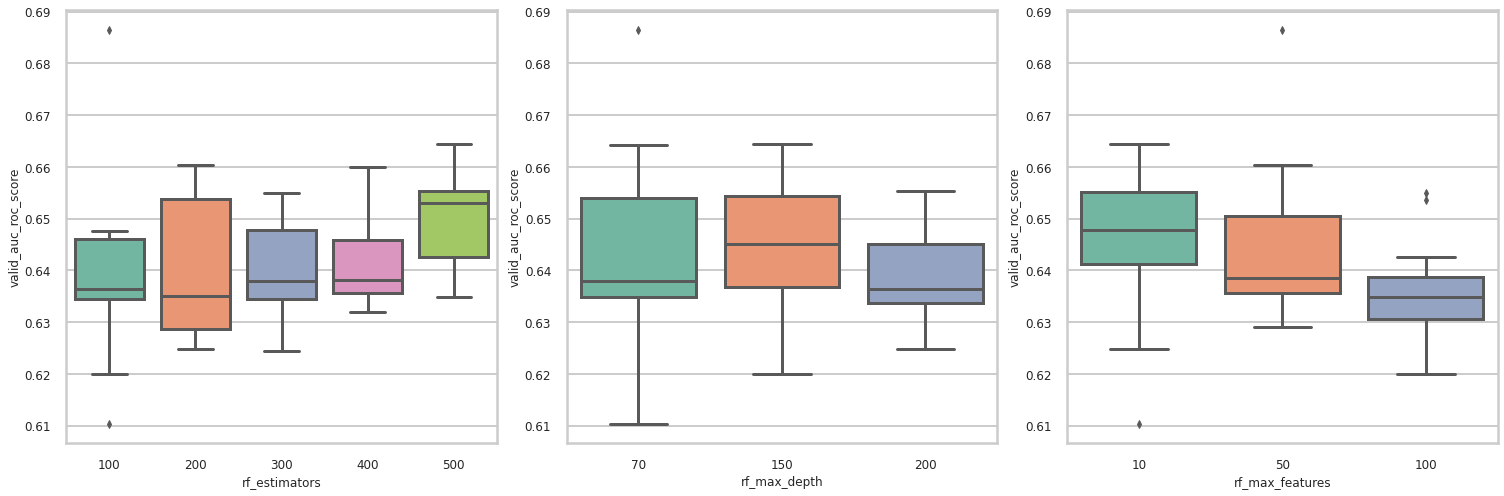

In [23]:
fig, ax = plt.subplots(1,3,figsize=(21,7))
sns.boxplot(data=perf_df, x="rf_estimators", y="valid_auc_roc_score", ax=ax[0])
sns.boxplot(data=perf_df, x="rf_max_depth", y="valid_auc_roc_score", ax=ax[1])
sns.boxplot(data=perf_df, x="rf_max_features", y="valid_auc_roc_score", ax=ax[2])
fig.tight_layout()

# Refined Grid Search

In [24]:
#  Retrieve model metadata and performance metrics stored in the filesystem from a hyperparameter search run.
cmp.get_filesystem_perf_results('ampl_output', pred_type='classification').sort_values(by='valid_roc_auc_score', ascending=False)

Found data for 47 models under ampl_output


,model_uuid,ampl_version,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_choice_score,train_roc_auc_score,train_prc_auc_score,train_precision,train_recall_score,train_num_compounds,train_accuracy_score,train_bal_accuracy,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,train_confusion_matrix,valid_roc_auc_score,valid_prc_auc_score,valid_precision,valid_recall_score,valid_num_compounds,valid_accuracy_score,valid_bal_accuracy,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,valid_confusion_matrix,test_roc_auc_score,test_prc_auc_score,test_precision,test_recall_score,test_num_compounds,test_accuracy_score,test_bal_accuracy,test_npv,test_matthews_cc,test_kappa,test_cross_entropy,test_confusion_matrix
27,3d312e0a-cce2-475e-88bf-7ccd0b8a7966,1.1.0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,100,50,70.0,NaN,NaN,0.686537,0.999984,0.999821,0.991103,0.991103,6117,0.998365,0.995102,0.999100,0.990203,0.990203,0.055536,"[[[5550, 5], [5, 557]]]",0.686537,0.284740,0.750000,0.077922,765,0.904575,0.537508,0.906209,0.221868,0.124590,0.308388,"[[[686, 2], [71, 6]]]",0.777241,0.487106,0.771429,0.281250,765,0.899346,0.634646,0.905479,0.426949,0.369966,0.305292,"[[[661, 8], [69, 27]]]"
16,d4e7e97c-05fe-49e6-a822-b1699866f7d2,1.1.0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,500,10,150.0,NaN,NaN,0.664442,0.999984,0.999821,0.996403,0.985765,6117,0.998365,0.992703,0.998561,0.990173,0.990156,0.057942,"[[[5553, 2], [8, 554]]]",0.664442,0.291960,0.666667,0.051948,765,0.901961,0.524521,0.903821,0.167264,0.083042,0.302953,"[[[686, 2], [73, 4]]]",0.800908,0.507376,0.782609,0.187500,765,0.891503,0.590013,0.894879,0.349236,0.266962,0.299787,"[[[664, 5], [78, 18]]]"
12,7df9110e-d267-4cf6-b325-9679d99dd7eb,1.1.0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,500,10,70.0,NaN,NaN,0.664206,0.999984,0.999821,0.998195,0.983986,6117,0.998365,0.991903,0.998382,0.990171,0.990140,0.058331,"[[[5554, 1], [9, 553]]]",0.664206,0.284698,0.714286,0.064935,765,0.903268,0.531014,0.905013,0.195995,0.104017,0.303424,"[[[686, 2], [72, 5]]]",0.815092,0.522855,0.720000,0.187500,765,0.888889,0.588518,0.894595,0.329857,0.259101,0.296688,"[[[662, 7], [78, 18]]]"
36,49952a1a-d869-44a9-aade-f3c1207945f2,1.1.0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,200,50,70.0,NaN,NaN,0.660365,0.999984,0.999821,0.996403,0.985765,6117,0.998365,0.992703,0.998561,0.990173,0.990156,0.055184,"[[[5553, 2], [8, 554]]]",0.660365,0.291714,0.750000,0.077922,765,0.904575,0.537508,0.906209,0.221868,0.124590,0.354775,"[[[686, 2], [71, 6]]]",0.805594,0.516196,0.756757,0.291667,765,0.899346,0.639107,0.906593,0.429596,0.377595,0.294656,"[[[660, 9], [68, 28]]]"
20,e6fcbdb8-9657-4b4d-868a-00ef89b1a03e,1.1.0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,400,10,150.0,NaN,NaN,0.659988,0.999984,0.999821,0.996403,0.985765,6117,0.998365,0.992703,0.998561,0.990173,0.990156,0.057870,"[[[5553, 2], [8, 554]]]",0.659988,0.276318,0.666667,0.051948,765,0.901961,0.524521,0.903821,0.167264,0.083042,0.305296,"[[[686, 2], [73, 4]]]",0.817895,0.528042,0.789474,0.156250,765,0.888889,0.575135,0.891421,0.319873,0.228895,0.295776,"[[[665, 4], [81, 15]]]"
18,b5cc42ec-66ef-4c94-ae10-26a87d5fdaff,1.1.0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,500,32,NaN,NaN,NaN,0.657449,0.999984,0.999821,1.000000,0.982206,6117,0.998365,0.991103,0.998203,0.990172,0.990124,0.055482,"[[[5555, 0], [10, 552]]]",0.657449,0.279896,0.750000,0.077922,765,0.904575,0.537508,0.906209,0.221868,0.124590,0.313898,"[[[686, 2], [71, 6]]]",0.794820,0.503760,0.777778,0.29166

In [25]:
# save the best model
model_class =cmp.copy_best_filesystem_models(pred_type="classification", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)
model_class.to_csv('best_class_model.csv')

Found data for 47 models under ampl_output
Copied df_classification_new_cutoff_label_model_3d312e0a-cce2-475e-88bf-7ccd0b8a7966.tar.gz


In [26]:
cmp.copy_best_filesystem_models(pred_type="classification", dest_dir=working_dir, 
                                result_dir='ampl_output', force_update=False)

Found data for 47 models under ampl_output


,model_uuid,ampl_version,model_type,dataset_key,featurizer,splitter,model_score_type,feature_transform_type,learning_rate,dropouts,layer_sizes,best_epoch,max_epochs,rf_estimators,rf_max_features,rf_max_depth,xgb_gamma,xgb_learning_rate,model_choice_score,train_roc_auc_score,train_prc_auc_score,train_precision,train_recall_score,train_num_compounds,train_accuracy_score,train_bal_accuracy,train_npv,train_matthews_cc,train_kappa,train_cross_entropy,train_confusion_matrix,valid_roc_auc_score,valid_prc_auc_score,valid_precision,valid_recall_score,valid_num_compounds,valid_accuracy_score,valid_bal_accuracy,valid_npv,valid_matthews_cc,valid_kappa,valid_cross_entropy,valid_confusion_matrix,test_roc_auc_score,test_prc_auc_score,test_precision,test_recall_score,test_num_compounds,test_accuracy_score,test_bal_accuracy,test_npv,test_matthews_cc,test_kappa,test_cross_entropy,test_confusion_matrix
27,3d312e0a-cce2-475e-88bf-7ccd0b8a7966,1.1.0,RF,df_classification_new_cutoff_label.csv,ecfp,scaffold,roc_auc,normalization,NaN,NaN,NaN,NaN,NaN,100,50,70.0,NaN,NaN,0.686537,0.999984,0.999821,0.991103,0.991103,6117,0.998365,0.995102,0.9991,0.990203,0.990203,0.055536,"[[[5550, 5], [5, 557]]]",0.686537,0.28474,0.75,0.077922,765,0.904575,0.537508,0.906209,0.221868,0.12459,0.308388,"[[[686, 2], [71, 6]]]",0.777241,0.487106,0.771429,0.28125,765,0.899346,0.634646,0.905479,0.426949,0.369966,0.305292,"[[[661, 8], [69, 27]]]"


# Test

In [27]:
! pip install molvs

In [28]:
from atomsci.ddm.pipeline import predict_from_model

In [29]:
#Jiang Mao's data
!wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_cur_final.csv

--2021-04-28 23:44:08--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/CYP3A4_cur_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3199248 (3.1M) [text/plain]
Saving to: ‘CYP3A4_cur_final.csv’

CYP3A4_cur_final.cs 100%[===================>]   3.05M  18.7MB/s    in 0.2s    

2021-04-28 23:44:08 (18.7 MB/s) - ‘CYP3A4_cur_final.csv’ saved [3199248/3199248]



In [75]:
mao = pd.read_csv('CYP3A4_cur_final.csv',index_col=0)
mao['new_active']=np.where(mao.VALUE_NUM_mean>=6.21,1,0)

In [76]:
mao_no_overlap = mao[~mao.base_rdkit_smiles.isin(df.base_rdkit_smiles)]

In [80]:
# Test loading model from tarball and running predictions
test = predict_from_model.predict_from_model_file(model_path='df_classification_new_cutoff_label_model_3d312e0a-cce2-475e-88bf-7ccd0b8a7966.tar.gz',
                            input_df = mao_no_overlap,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='new_active',
                            is_featurized=False,
                            dont_standardize=True)

Featurization = DynamicFeaturization with ecfp features
number of features: 1024


In [82]:
print("Jian Mao\'s prediction")
confusion = pd.crosstab(test.new_active_actual,test.new_active_pred, rownames=['actual'],colnames=['predicted'],margins=True)
display(confusion)
print('accuracy is:', (confusion.at[0,0]+confusion.at[1,1])/confusion.at['All','All'])

from sklearn.metrics import r2_score, mean_squared_error,roc_auc_score
#print(r2_score(test.new_active_actual, test.new_active_pred))
#print(mean_squared_error(test.new_active_actual, test.new_active_pred))
print('auc_score is:',roc_auc_score(test.new_active_actual,test.new_active_pred))

Jian Mao's prediction


predicted,0,1,All
actual,,,
0.0,12513,100,12613
1.0,1112,46,1158
All,13625,146,13771


accuracy is: 0.9119889623121051
auc_score is: 0.5158976667848385


In [69]:
!wget https://raw.githubusercontent.com/js5783/E4511-2021-Shen/main/Dataset/delaney_curated_final.csv

--2021-04-29 00:32:37--  https://raw.githubusercontent.com/js5783/E4511-2021-Shen/main/Dataset/delaney_curated_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2231626 (2.1M) [text/plain]
Saving to: ‘delaney_curated_final.csv.3’

delaney_curated_fin 100%[===================>]   2.13M  --.-KB/s    in 0.1s    

2021-04-29 00:32:37 (20.6 MB/s) - ‘delaney_curated_final.csv.3’ saved [2231626/2231626]



In [83]:
shen = pd.read_csv('delaney_curated_final.csv',index_col=0)
shen['new_active']=np.where(df_test.VALUE_NUM_mean>=6.21,1,0)

In [84]:
shen_no_overlap = shen[~shen.base_rdkit_smiles.isin(df.base_rdkit_smiles)]

In [85]:
test = predict_from_model.predict_from_model_file(model_path='df_classification_new_cutoff_label_model_3d312e0a-cce2-475e-88bf-7ccd0b8a7966.tar.gz',
                            input_df = shen_no_overlap,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='new_active',
                            is_featurized=False,
                            dont_standardize=True)

Featurization = DynamicFeaturization with ecfp features
number of features: 1024


In [86]:
print("Jieru Shen\'s prediction")
confusion = pd.crosstab(test.new_active_actual,test.new_active_pred, rownames=['actual'],colnames=['predicted'],margins=True)
display(confusion)
print('accuracy is:', (confusion.at[0,0]+confusion.at[1,1])/confusion.at['All','All'])

from sklearn.metrics import r2_score, mean_squared_error,roc_auc_score
#print(r2_score(test.new_active_actual, test.new_active_pred))
#print(mean_squared_error(test.new_active_actual, test.new_active_pred))
print('auc_score is:',roc_auc_score(test.new_active_actual,test.new_active_pred))

Jieru Shen's prediction


predicted,0,1,All
actual,,,
0.0,6889,84,6973
1.0,843,10,853
All,7732,94,7826


accuracy is: 0.8815486838742652
auc_score is: 0.49983843224468716


In [87]:
!wget https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/data_for_model_MAOA.csv

--2021-04-29 00:41:28--  https://raw.githubusercontent.com/jm5159/E4511-2021-Mao/master/Dataset/data_for_model_MAOA.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 355064 (347K) [text/plain]
Saving to: ‘data_for_model_MAOA.csv’

data_for_model_MAOA 100%[===================>] 346.74K  --.-KB/s    in 0.03s   

2021-04-29 00:41:28 (9.87 MB/s) - ‘data_for_model_MAOA.csv’ saved [355064/355064]



In [96]:
fu=pd.read_csv('data_for_model_MAOA.csv')
fu=fu.iloc[:,2:]
fu['new_active']=np.where(fu.VALUE_NUM_mean>=6.21,1,0)

In [97]:
fu_no_overlap = fu[~fu.base_rdkit_smiles.isin(df.base_rdkit_smiles)]

In [98]:
test = predict_from_model.predict_from_model_file(model_path='df_classification_new_cutoff_label_model_3d312e0a-cce2-475e-88bf-7ccd0b8a7966.tar.gz',
                            input_df = fu_no_overlap,
                            id_col='compound_id',
                            smiles_col='base_rdkit_smiles',
                            response_col='new_active',
                            is_featurized=False,
                            dont_standardize=True)

Featurization = DynamicFeaturization with ecfp features
number of features: 1024


In [100]:
print("Shulu Fu\'s prediction")
confusion = pd.crosstab(test.new_active_actual,test.new_active_pred, rownames=['actual'],colnames=['predicted'],margins=True)
display(confusion)
#print('accuracy is:', (confusion.at[0,0]+confusion.at[1,1])/confusion.at['All','All'])

from sklearn.metrics import r2_score, mean_squared_error,roc_auc_score
#print(r2_score(test.new_active_actual, test.new_active_pred))
#print(mean_squared_error(test.new_active_actual, test.new_active_pred))
print('auc_score is:',roc_auc_score(test.new_active_actual,test.new_active_pred))

Shulu Fu's prediction


predicted,0,All
actual,,
0.0,3016,3016
1.0,504,504
All,3520,3520


auc_score is: 0.5
